# Классификация пород кошек и собак по лицу

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

Импорт библиотек

In [3]:
from keras import utils
from keras import layers
from keras.models import Sequential
from keras.metrics import SparseTopKCategoricalAccuracy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import time
from pathlib import Path

Загружаем датасет, задаём размер изображений и разделяем датасет на обучающую и тестовую выборки

In [4]:
url = 'http://www.soshnikov.com/permanent/data/petfaces.tar.gz'
dataset = Path(utils.get_file('petfaces', origin=url, untar=True))

img_size = 256, 256

train_set = utils.image_dataset_from_directory(
    dataset, 
    validation_split=0.2, 
    subset='training',
    seed=3000,
    image_size=img_size,
    batch_size=32)

test_set = utils.image_dataset_from_directory(
    dataset, 
    validation_split=0.2, 
    subset='validation',
    seed=3000, 
    image_size=img_size,
    batch_size=32)

Found 3211 files belonging to 35 classes.
Using 2569 files for training.
Found 3211 files belonging to 35 classes.
Using 642 files for validation.


Разделим датасет на классы: кошки и собаки, использую префикс cats или dogs

In [5]:
class_names = train_set.class_names

class_cats = []
class_dogs = []

for i in range(len(class_names)):
    if class_names[i].startswith('cat'):
        class_cats.append(i)
    if class_names[i].startswith('dog'):
        class_dogs.append(i)

train_set = train_set.cache().shuffle(3000 // 2).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Определим модель, подобрав оптимальные гиперпараметры. Я долго эксперементировал ,чтобы точность была как можно выше. Архитектура представляет из себя: 4 раза применить свёртку и пуллинг, после чего Dense 2 раза, в конце Softmax. В начале немного повращаем, поотражаем и позумим картинки для лучшей точности

In [6]:
model = Sequential()

model.add(layers.RandomFlip("horizontal"))
model.add(layers.RandomRotation(0.1))
model.add(layers.RandomZoom(0.1))
model.add(layers.Conv2D(8, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(16, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(class_names)))
model.add(layers.Softmax())

Начнём обучение. Оно будет происходить в течение 30 эпох. В качестве оптимизатора используем Adam

In [7]:
top3_accuracy = SparseTopKCategoricalAccuracy(k=3, name='top3_accuracy')

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

start_time = time.time()

model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy', top3_accuracy])

epochs = 30

history = model.fit(train_set, validation_data=test_set, epochs=epochs)

Epoch 1/30


81/81 ━━━━━━━━━━━━━━━━━━━━ 28s 144ms/step - accuracy: 0.0440 - loss: 26.0136 - top3_accuracy: 0.1239 - val_accuracy: 0.1340 - val_loss: 3.1310 - val_top3_accuracy: 0.2960
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.1646 - loss: 3.0504 - top3_accuracy: 0.3397 - val_accuracy: 0.2632 - val_loss: 2.6786 - val_top3_accuracy: 0.5202
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.2864 - loss: 2.6157 - top3_accuracy: 0.4976 - val_accuracy: 0.3069 - val_loss: 2.5113 - val_top3_accuracy: 0.5717
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.3439 - loss: 2.3220 - top3_accuracy: 0.5971 - val_accuracy: 0.4065 - val_loss: 2.0527 - val_top3_accuracy: 0.6713
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.4086 - loss: 2.0804 - top3_accuracy: 0.6579 - val_accuracy: 0.4502 - val_loss: 1.8496 - val_top3_accuracy: 0.7196
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.4351 - loss: 1.9229 - top3_accuracy: 0

После обучения посчитаем все необходимые метрики. Метрики хранятся в "истории" обученной модели, получим их по ключу

In [8]:
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_top3_accuracy = history.history['top3_accuracy']
test_top3_accuracy = history.history['val_top3_accuracy']

end_time = time.time()

Определим функцию, которая будет строить графики. Она принимает различные надписи, количество эпох и данные, по которым график будет строиться

In [9]:
def graf(title, label1, label2, epochs, val1, val2):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 3, 1)
    plt.plot(range(epochs), val1, label=label1)
    plt.plot(range(epochs), val2, label=label2)
    plt.legend()
    plt.grid()
    plt.title(title)

    plt.show()

Построим графики для каждой метрики

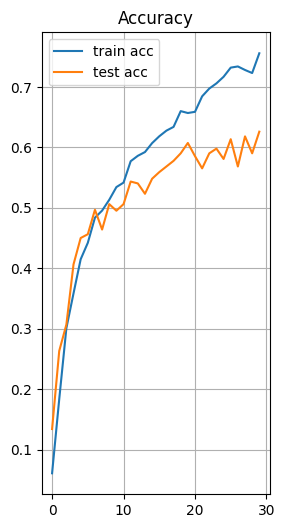

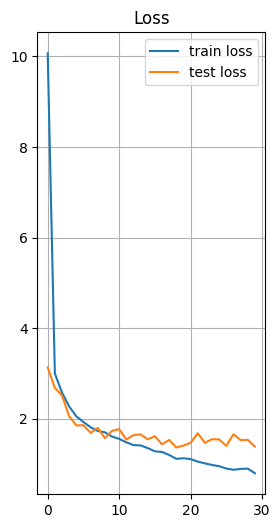

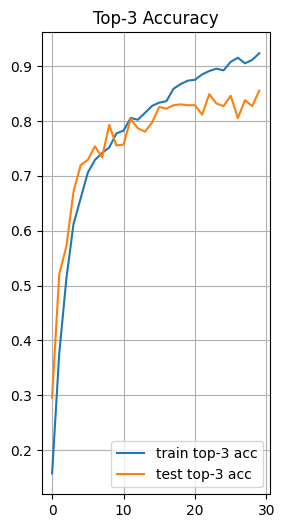

In [10]:
graf('Accuracy', 'train acc', 'test acc', epochs, train_accuracy, test_accuracy)
graf('Loss', 'train loss', 'test loss', epochs, train_loss, test_loss)
graf('Top-3 Accuracy', 'train top-3 acc', 'test top-3 acc', epochs, train_top3_accuracy, test_top3_accuracy)

Посчитаем точность бинарной классификации - с какой точностью картинка оказывалась в нужном классе (разметили выше)

In [11]:
correct, total = 0, 0

for x, y in test_set:
    y_pred = np.argmax(model.predict(x), axis=1)
    correct_cats = sum([y_pred[i] in class_cats and y[i] in class_cats for i in range(len(y))])
    correct_dogs = sum([y_pred[i] in class_dogs and y[i] in class_dogs for i in range(len(y))])
    correct += correct_cats + correct_dogs
    total += len(y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Посчитаем confusion matrix

In [12]:
y_real = np.array([])
y_pred = np.array([])

for x, y in test_set:
    y_real = np.concatenate((y_real, y), axis=None)
    y_pred = np.concatenate((y_pred, np.argmax(model.predict(x), axis=1)), axis=None)    

confusion_matrix = tf.math.confusion_matrix(y_real, y_pred, num_classes=len(class_names))
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in class_names], columns = [i for i in class_names])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Построим матрицу

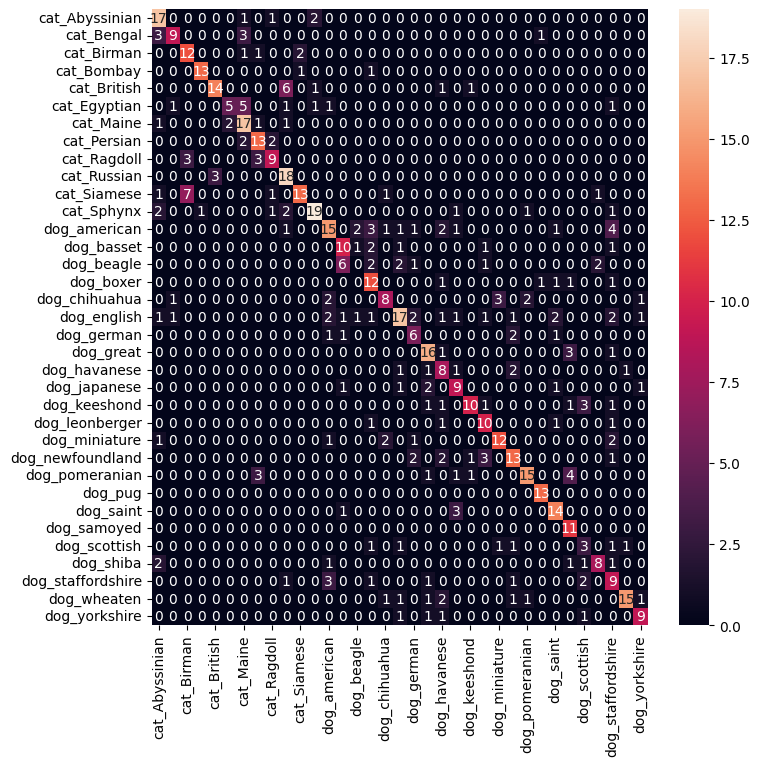

In [13]:
plt.figure(figsize = (8, 8))
sn.heatmap(df_cm, annot=True)
plt.show()

Выведем все метрики и время, которое было затрачено на обучение

In [14]:
print('\nFinal train accuracy:', train_accuracy[epochs - 1])
print('Final test accuracy:', test_accuracy[epochs - 1])
print('\nFinal train loss:', train_loss[epochs - 1])
print('Final test loss:', test_loss[epochs - 1])
print('\nBinary classification accuracy:', correct / total)
print('\nFinal train top-3 accuracy:', train_top3_accuracy[epochs - 1])
print('Final test top-3 accuracy:', test_top3_accuracy[epochs - 1])
print("\ntime =", end_time - start_time, '\n')


Final train accuracy: 0.7559361457824707
Final test accuracy: 0.6261682510375977

Final train loss: 0.7920054793357849
Final test loss: 1.380981206893921

Binary classification accuracy: 0.9657320872274143

Final train top-3 accuracy: 0.923316478729248
Final test top-3 accuracy: 0.855140209197998

time = 330.9857678413391 

